# Is Suicide a First World Problem?

It's been said numerous times that suicide is a problem of the first world, the richest countries[1], the happiest countries[2][3].  It almost feels like a cathartic jab at the successful with data to back it up.  However, there are other sources emerging that suggest that suicide and mental illness are really a global problem[4][5][6].  I want to test the first hypothesis by analyzing the relationship between suicide and some standard global development indicators[7].

The first analysis I want to do is on indicators that define a developed country[7]:

* Higher Life Expectancy
* Higher Literacy
* Higher Income
* Lower Fertility

If suicide truly is a first-world problem, I would expect to see a strong correlation between some or all of these and the per capita suicide rate.  The data sets I am considering are already normalized by population.

### References:
1. https://bamituniabamu.wordpress.com/2013/05/31/developed-countries-and-its-love-for-suicide-a-paradox-yet-unexplained/
2. https://well.blogs.nytimes.com/2011/04/22/happiest-places-post-highest-suicide-rates/?_r=0
3. http://www.conservativehome.com/the-deep-end/2015/07/why-do-the-happiest-countries-have-the-highest-suicide-rates.html
4. http://www.who.int/mental_health/prevention/suicide/suicideprevent/en/
5. https://www.quora.com/Why-is-depression-more-prevalent-in-first-world-countries
6. http://www.psyweb.com/news/depression/depression-and-anxiety-found-all-around-the-world
7. https://en.wikipedia.org/wiki/Developing_country#Definition

### Data Sources:
- Worlbank Developent Indicators
  - Fertility, http://data.worldbank.org/indicator/SP.DYN.TFRT.IN?view=map&year=1960
  - Literacy, http://data.worldbank.org/indicator/SE.ADT.LITR.ZS?end=2010&start=1990&view=map&year=1990
  - GDP, http://data.worldbank.org/indicator/NY.GDP.PCAP.CD?view=map
  - GNI, http://data.worldbank.org/indicator/NY.GNP.PCAP.CD?view=map&year=2015
  - Life Expectency, http://data.worldbank.org/indicator/SP.DYN.LE00.IN?end=2014&start=2014&view=map&year=2014
  - http://data.worldbank.org/data-catalog/world-development-indicators
- Democracy Indicators
  - http://www.democracybarometer.org/dataset_en.html
- ISO3 Country Codes
  - https://unstats.un.org/unsd/tradekb/Knowledgebase/Country-Code
- Suicide Rates
  - https://data.oecd.org/healthstat/suicide-rates.htm

In [114]:
%matplotlib inline

from IPython.core.pylabtools import figsize
figsize(15,9)

import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt

import pymc3 as pm

from sklearn import feature_extraction as skfe
from sklearn import ensemble as sken
from sklearn import linear_model as sklin

import copy

import os


# Utility Functions
def is_num(x):
    try:
        float(x)
        return True
    except:
        return False

def get_data(df, field, data_dict):
    for index, row in df.iterrows():
        country = row['Country Name']
        cc = row['Country Code']
        
        if cc not in data_dict:
            data_dict[cc] = {}
        
        for k in list(row.keys()):
            if is_num(k):
                str_k = str(k)
                if str_k not in data_dict[cc]:
                    data_dict[cc][str_k] = {}
                
                data_dict[cc][str_k][field] = row[k]
                

def remove_zeros(df):
    for f in list(df):
        df = df[df[f] != 0]
    
    return df.dropna()

def detrend(df, f_center, f_spread, plot=False):
    yr_centers = {}
    yr_spreads = {}
    headers = list(df)
    
    detrended = pd.DataFrame()
    for i, f in enumerate([x for x in headers if x != 'yr']):
        yr_centers = {}
        yr_spreads = {}
        for yr in df['yr'].unique():
            yr_centers[yr] = f_center(df[df['yr'] == yr][f])
            yr_spreads[yr] = f_spread(df[df['yr'] == yr][f])
        
        sorted_avgs    = sorted(list(yr_centers.items()), key=lambda x: int(x[0]))
        sorted_spreads = sorted(list(yr_spreads.items()), key=lambda x: int(x[0]))
        
        years    = list(map(lambda x: x[0], sorted_avgs))
        averages = list(map(lambda x: x[1], sorted_avgs))
        spreads  = list(map(lambda x: x[1], sorted_spreads))

        if plot:
            plt.subplot(2,int(len(headers)/2), i + 1)
            plt.scatter(df['yr'], df[f], label='data')
            plt.plot(years, averages, label='mean', c='g')
            plt.fill_between(
                years,
                np.array(averages) + np.array(spreads),
                np.array(averages) - np.array(spreads),
                color='#d34545',
                alpha=0.5
            )
            plt.ylabel(f)
            plt.xlabel('yr')
            
        detrended[f] = df.apply(lambda x: (x[f] - yr_centers[x['yr']])/yr_spreads[x['yr']], axis=1)
    
    if plot:
        plt.suptitle('Center and Spread Trends')
        plt.show()
    
    
    print(headers)        
    print(list(detrended))    
    
    return detrended.dropna()

def inverse_affine_transform(x, y, minA=-100.0, maxA=100.0, minB=-100.0, maxB=100.0, maxE=10.0, N=20000, Ntake=10000):
    x_pos = x.as_matrix() + min(x) + 1.0
    y_pos = y + min(y) + 1.0
    with pm.Model():
        a = pm.Uniform('a', lower=minA, upper=maxA)
        b = pm.Uniform('b', lower=minB, upper=maxB)
        
        mdl = a/(x_pos + b)
        
        error = pm.Uniform('sigma', lower=0.0, upper=maxE)

        likelihood = pm.Normal('likelihood', mu=mdl, sd=error, observed=y_pos)
        
        start = pm.find_MAP()
        step = pm.Metropolis()
        trace = pm.sample(N, step, start=start)

    pm.traceplot(trace)
    plt.show()

    a_hat = np.mean(trace['a'][Ntake:])
    b_hat = np.mean(trace['b'][Ntake:])
    
    return a_hat/(x_pos + b_hat)

def plot_correlations(df, title='Detrended Indicators', lit=False):
    print('Suicide VS Fertility\n r = %.4f, p = %s\n' % sp.stats.pearsonr(df['TARGET'], df['fert']))    
    print('Suicide VS GNI\n r = %.4f, p = %s\n' % sp.stats.pearsonr(df['TARGET'], df['gni']))
    print('Suicide VS Life Expectancy\n r = %.4f, p = %s\n' % sp.stats.pearsonr(df['TARGET'], df['lex']))
    
    if lit:
        print('Suicide VS Literacy\n r = %.4f, p = %s\n' % sp.stats.pearsonr(df['TARGET'], df['lit']))        

    pd.tools.plotting.scatter_matrix(df)
    plt.suptitle(title)
    plt.show()

In [93]:
if True: # Read in data files
    data_dir = 'data/'

    # Showing all of the available files
    #     for f in sorted(os.listdir(data_dir)):
    #         print(f)


    fert_file = data_dir + 'fertility_per_woman_by_country.csv'
    gdp_file = data_dir + 'gdp_per_capita_by_country.csv'
    gni_file = data_dir + 'gni_per_capita_by_country.csv'
    life_file = data_dir + 'life_expectancy_by_country.csv'
    lit_file = data_dir + 'literacy_by_country.csv'

    suicide_file = data_dir + 'suicide_per_100k_by_country.csv'

    # Reading in the data files
    frt_df = pd.read_csv(fert_file)
    gdp_df = pd.read_csv(gdp_file)
    gni_df = pd.read_csv(gni_file)
    lex_df = pd.read_csv(life_file)
    lit_df = pd.read_csv(lit_file)

    scd_df = pd.read_csv(suicide_file)


    # Combining the data into a single data structure
    data_dict = {}
    get_data(frt_df, 'fert', data_dict)
    # get_data(gdp_df, 'gdp',  data_dict) # GDP and GNI are very highly correlated - there is no point using both
    get_data(gni_df, 'gni',  data_dict)
    get_data(lex_df, 'lex',  data_dict)
    get_data(lit_df, 'lit',  data_dict)

    target_name = 'TOT'
    for index, row in scd_df.iterrows():
        cc = row['LOCATION']
        yr = str(row['TIME'])
        scd = row['Value']
        subj = row['SUBJECT']

        if cc not in data_dict:
            data_dict[cc] = {}

        if yr not in data_dict[cc]:
            data_dict[cc][yr] = {}

        if subj == target_name:
            data_dict[cc][yr]['TARGET'] = scd

In [94]:
if True: # Convert to Matrix
    # Creating input dictionaries, preparing for DictVectorizer transformation
    input_dicts = []

    for cc in data_dict:
        for yr in data_dict[cc]:
            row = copy.deepcopy(data_dict[cc][yr])
    #         row['ctry'] = cc
            row['yr'] = int(yr)
            input_dicts.append(row)

    DV = skfe.DictVectorizer(sparse=False)
    matrix_with_nans = DV.fit_transform(input_dicts)
    
    # Showing the field names in the data
    print(DV.feature_names_)
    print(matrix_with_nans.shape)

['TARGET', 'fert', 'gni', 'lex', 'lit', 'yr']
(15048, 6)


In [104]:
# How many nans? How many zeros?
df_with_nan = pd.DataFrame(matrix_with_nans, columns=DV.feature_names_)
for n in list(df_with_nan):
    print("%s has %s nans" % (n, np.count_nonzero(np.isnan(df_with_nan[n].as_matrix()))))
    print("%s has %s zeros" % (n, np.count_nonzero(df_with_nan[n].as_matrix())))

matrix_no_nan = np.nan_to_num(matrix_with_nans)

# Creating a new dataframe
all_df = pd.DataFrame(matrix_no_nan, columns=DV.feature_names_)

TARGET has 0 nans
TARGET has 1807 zeros
fert has 1774 nans
fert has 15048 zeros
gni has 5367 nans
gni has 15048 zeros
lex has 1795 nans
lex has 15048 zeros
lit has 14088 nans
lit has 15048 zeros
yr has 0 nans
yr has 15048 zeros


It looks like there are a significant number of null values

Suicide VS Fertility
 r = -0.2317, p = 1.30717436804e-182

Suicide VS GNI
 r = 0.2490, p = 2.18999425805e-211

Suicide VS Life Expectancy
 r = 0.2451, p = 8.98939056185e-205



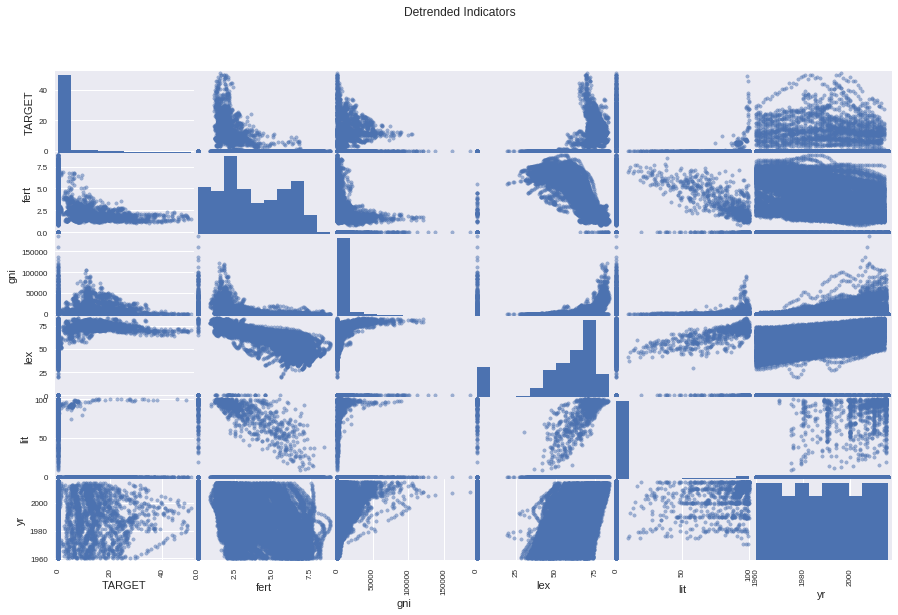

In [105]:
plot_correlations(all_df)

We will create a new dataframe for transformation and analysis.  Literacy is very sparsely populated, so we will not consider that for now.  The correlation of inverse fertility is already apparent.

In [106]:
no_le_df = all_df.copy(deep=True)
del no_le_df['lit']

nz_no_le_df = remove_zeros(no_le_df)
# nz_no_le_df['1/fert'] = inverse_affine_transform(nz_no_le_df['fert'], nz_no_le_df['TARGET'], N=100000)

Suicide VS Fertility
 r = -0.4150, p = 1.68850354708e-65

Suicide VS GNI
 r = 0.0426, p = 0.0939036601599

Suicide VS Life Expectancy
 r = 0.0671, p = 0.00829605273331



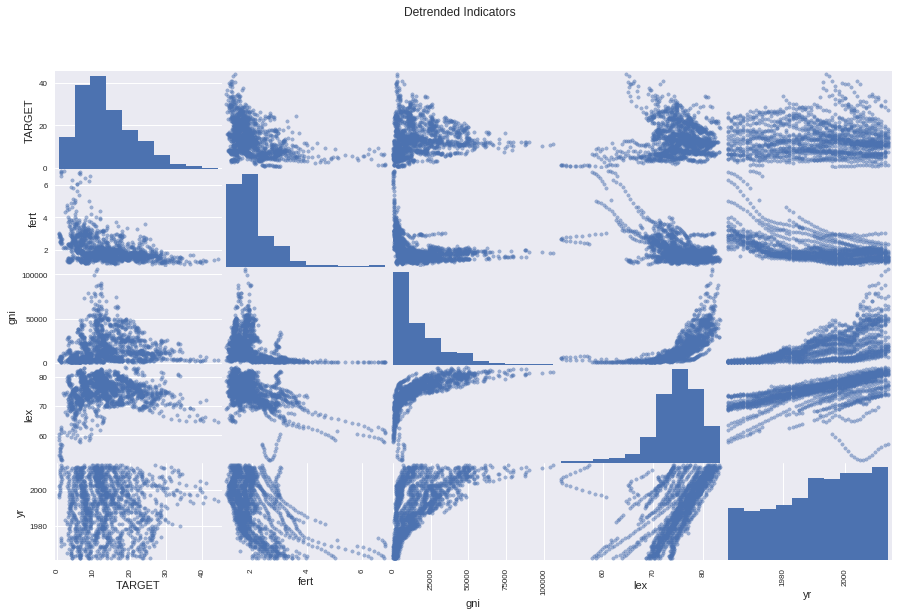

In [107]:
plot_correlations(nz_no_le_df)

We can see fertility has a an inverse relationship with suicides, but the rest of the indicators appear very weakly correlated.  However, some indicators show a strong mean and variance trend related to year, so we should normalize.

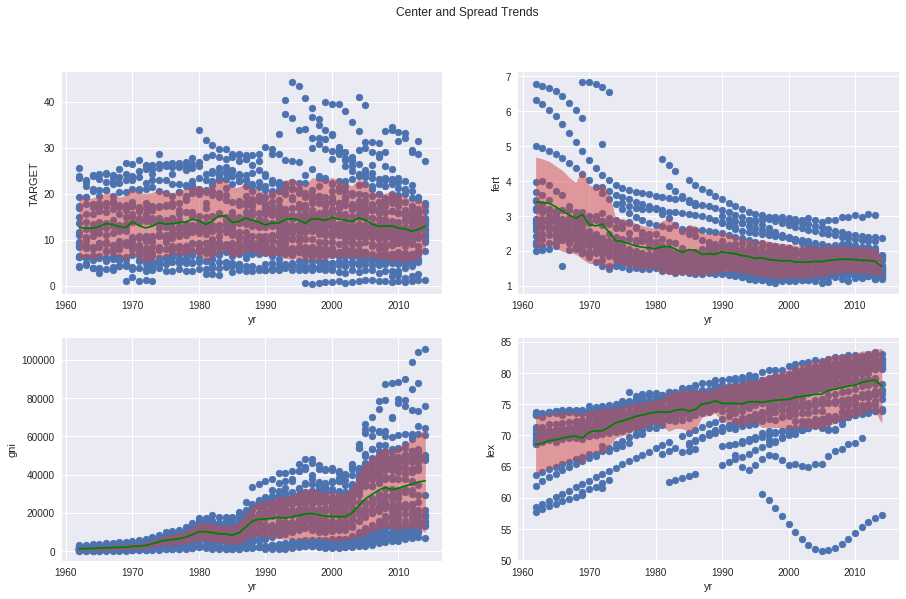

['TARGET', 'fert', 'gni', 'lex', 'yr']
['TARGET', 'fert', 'gni', 'lex']


In [115]:
no_le_detrended = detrend(remove_zeros(nz_no_le_df), np.mean, np.std, True)

Suicide VS Fertility
 r = -0.5274, p = 1.5083148149e-111

Suicide VS GNI
 r = 0.2647, p = 3.18424311029e-26

Suicide VS Life Expectancy
 r = 0.1283, p = 4.10789899904e-07



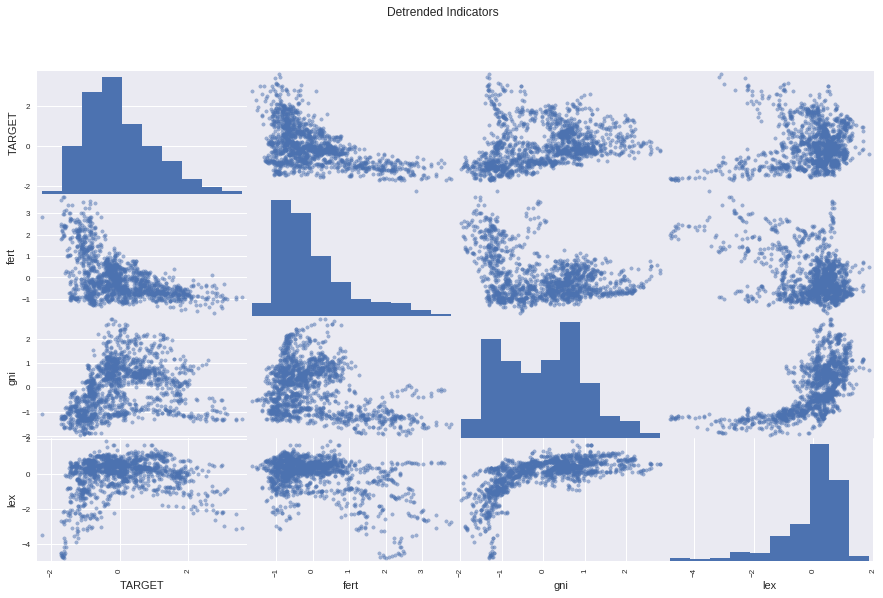

In [109]:
plot_correlations(no_le_detrended)

When we make the data homoskedastic by year we can see that all development indicators show a relationship with suicide.  What's interesting is that the correlation with inverse fertility shows the strongest indication.

Now we add literacy back into the mix.

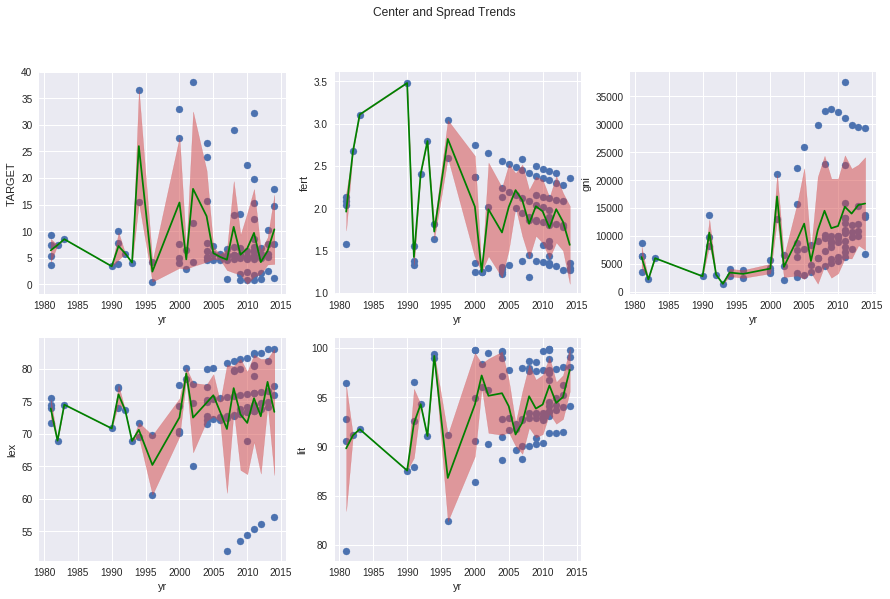

['TARGET', 'fert', 'gni', 'lex', 'lit', 'yr']
['TARGET', 'fert', 'gni', 'lex', 'lit']


In [116]:
lit_df = detrend(remove_zeros(all_df), np.mean, np.std, True)

Suicide VS Fertility
 r = -0.6474, p = 2.83220643364e-11

Suicide VS GNI
 r = 0.0820, p = 0.458532015818

Suicide VS Life Expectancy
 r = 0.1746, p = 0.112209693558

Suicide VS Literacy
 r = 0.5505, p = 5.78666608149e-08



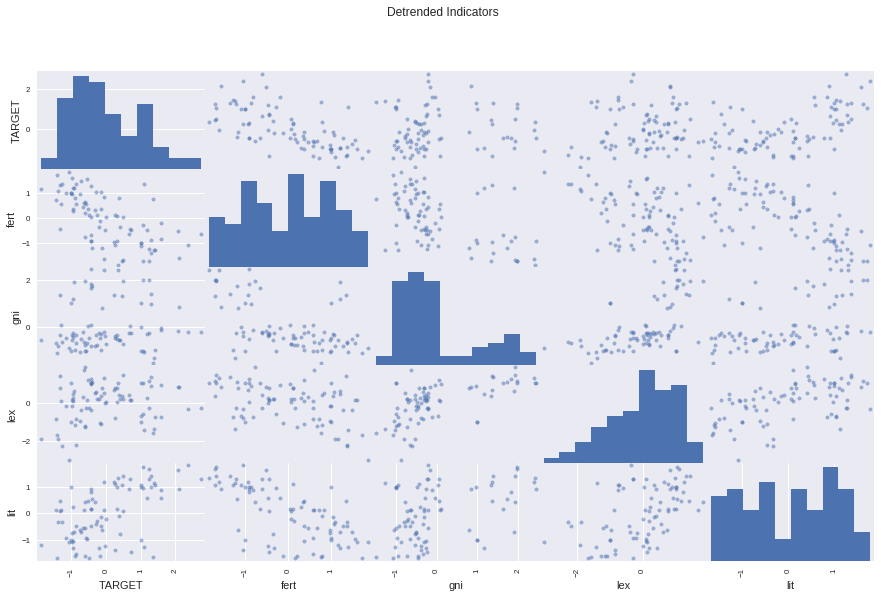

In [111]:
plot_correlations(lit_df, lit=True)

While very sparse, literacy also appears to be a moderate indicator.  However, the sparsity itself makes me less confident about this result.  It's interesting that fertility and life expectancy maintained their correlation strength, but the variance estimated for detrending is vastly less stable with such a reduced sample size, and what little correlation there was with GNI is almost completely gone now.